# Contexto e motivação

Em uma Rede Neural Recorrente, é introduzido o conceito de contexto e tempo, ou seja, **sequências**.

Em um problema de classificação de palavras, podemos ter a seguinte frase:

        Eu acordo cedo.

Nesse caso, a palavra 'acordo' é um **verbo**. Porém, na frase:

        Nós fizemos um acordo.

a palavra acordo é um **substantivo**. Dessa forma, dependendo do contexto, uma palavra pode ter classificações diferentes.

Uma rede MLP não consegue guardar o processamento anterior para diferenciar essas classificações diferentes para o elemento de entrada. Esse modelo não incorpora a relação entre palavras, já que recebe uma entrada de cada vez e atualiza seus pesos de acordo com a informação individual de cada palavra.

Em resumo, as redes 'feed-forward' apresentam limitações para lidar com sequências. Em grande parte, essas limitações estão associadas com a **incapacidade de guardar memória** das instâncias anteriores.

Por esse motivo são utilizadas as Redes Neurais Recorrentes, que diferente de unidades 'feed-forward', elas guardam seu próprio estado, compondo uma memória interna. **Além de dar uma saída, a RNN também devolve a saída como entrada da próxima etapa.**

## Resumo

O que é a memória de sequência:

- A memória humana ao processar sequências não memoriza elementos individuais, mas, sim, o padrão que relaciona os elementos em uma determinada ordem. Redes neurais recorrentes (RNN) foram projetadas com o mesmo propósito.

Tipos de dados sequenciais:

- Quaisquer conjuntos de dados onde cada amostra pode ser dividida em eventos individuais, sendo a ordem dos eventos um fator relevante. Por exemplo: texto, voz, partitura musical, vídeo etc.

Limitações do Multi-Layer Perceptron (MLP):

- Apesar de ser possível aplicar o MLP no processamento de sequências, ele apresenta uma série de limitações em grande parte relacionadas à sua incapacidade de memorizar acontecimentos passados. 

Motivação para o uso de Redes Neurais Recorrentes:

- As limitações do MLP levaram à proposição de uma nova arquitetura, a RNN, capaz de guardar uma memória interna de acontecimentos passados, levando-os em consideração ao processar novos eventos.

# Modelo básico

Modelo básico de RNN com uma camada recorrente e uma camada MLP:

                                retroalimentação
                                      Ht
                                    ------
                                    |    |
                                    v    |
        Entrada  --->  Camada recorrente ---> Camada MLP ---> Saída
        Letra                                                 Classe
        Xt

        Sendo: 
        X = {N,a,d,y,a,n};
        Xt = entrada t da sequência (N -> t1, a -> t2, ...)
        Ht = estado interno (memória) no tempo t;

A camada Recorrente passa sua saída para a camada MLP e retroalimenta a próxima etapa com essa saída.

- Entrada: Xt e H(t-1);
- Saída: Ht

A camada recorrente é capaz de representar a relação entre elementos através da atualização cumulativa de sua memória interna, ou seja, a memória do passo t é atualizada de acordo com a memória do passo t-1, havendo portanto uma dependência temporal.

O grande poder da RNN está no acúmulo de sua memória interna. Paralelizar o processamento dos elementos de uma sequência seria equivalente a processar cada elemento de forma independente, sem considerar a relação entre eles. Dessa forma, as RNN possuem um gargalo no processo de paralelização.


# Classificando nomes com uma Character-Level-RNN

Recebendo um nome, temos que classificar a nacionalidade desse nome.


## Preparação dos dados

In [3]:
!wget https://download.pytorch.org/tutorial/data.zip
!unzip data.zip

--2021-10-18 22:29:56--  https://download.pytorch.org/tutorial/data.zip
Resolving download.pytorch.org (download.pytorch.org)... 13.226.14.36, 13.226.14.109, 13.226.14.112, ...
Connecting to download.pytorch.org (download.pytorch.org)|13.226.14.36|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 2882130 (2.7M) [application/zip]
Saving to: ‘data.zip’

data.zip            100%[===================>]   2.75M  --.-KB/s    in 0.1s    

2021-10-18 22:29:56 (25.8 MB/s) - ‘data.zip’ saved [2882130/2882130]

Archive:  data.zip
   creating: data/
  inflating: data/eng-fra.txt        
   creating: data/names/
  inflating: data/names/Arabic.txt   
  inflating: data/names/Chinese.txt  
  inflating: data/names/Czech.txt    
  inflating: data/names/Dutch.txt    
  inflating: data/names/English.txt  
  inflating: data/names/French.txt   
  inflating: data/names/German.txt   
  inflating: data/names/Greek.txt    
  inflating: data/names/Irish.txt    
  inflating: data/names/Ital

In [4]:
import os
import unicodedata
import numpy as np

def le_arquivo(diretorio):
    nomes = open(diretorio).read().split('\n')
    nomes = [unicodedata.normalize('NFKD', nome).encode('ascii','ignore') for nome in nomes] # retira os acentos

    nacionalidade = diretorio.split('/')[-1].split('.')[0]
    nacionalidades = np.repeat(nacionalidade, len(nomes)) # repete uma categoria por nome (Portugues, Silva), (Portugues, Pereira), etc

    # retorna a lista de nomes e a lista de nacionalidades para cada arquivo
    # como estamos lendo arquivo por arquivo, as nacionalidades pra cada 
    # arquivo serão as mesmas. 
    return nomes, nacionalidades 

In [5]:
dir = './data/names'
arquivos = sorted(os.listdir(dir))

dados = [] # lista de listas de todos os nomes
rotulos = [] # lista de listas de todas as nacionalidades
for arquivo in arquivos:
    nomes, nacionalidades = le_arquivo(os.path.join(dir, arquivo))

    dados.append(nomes)
    rotulos.append(nacionalidades)

print('Nacionalidade 0:')
print(dados[0][0:5])
print(rotulos[0][0:5])

print('\nNacionalidade 1:')
print(dados[1][0:5])
print(rotulos[1][0:5])

Nacionalidade 0:
[b'Khoury', b'Nahas', b'Daher', b'Gerges', b'Nazari']
['Arabic' 'Arabic' 'Arabic' 'Arabic' 'Arabic']

Nacionalidade 1:
[b'Ang', b'Au-Yong', b'Bai', b'Ban', b'Bao']
['Chinese' 'Chinese' 'Chinese' 'Chinese' 'Chinese']


Obs: b antes dos nomes significa que é uma encodificação em bytes da string, por conta da normalização com a biblioteca unicodedata. Para usarmos a string novamente temos que utilizar nome = nome.decode('utf-8').

In [6]:
# Convertendo as nacionalidades (labels) para tensores

import torch

# Associamos um inteiro para cada nacionalidade:
categorias = [arquivo.split('.')[0] for arquivo in arquivos]
def labelToTensor(str):
    posicao = categorias.index(str) # pega o índice que a categoria está na lista de categorias
    return torch.LongTensor([posicao]) # transforma em Tensor de inteiro de 64bits

# Exemplo:
print('Rótulo original:', rotulos[8][0])
print('Rótulo transformado em tensor de inteiro:', labelToTensor(rotulos[8][0]))

Rótulo original: Irish
Rótulo transformado em tensor de inteiro: tensor([8])


In [117]:
# Convertendo os nomes para tensor
# Vamos utilizar a representação One-Hot para codificar os nomes.
# https://en.wikipedia.org/wiki/One-hot

# Cada letra é transformada em um dicionário de 0's com tamanho igual
# a todas as letras possíveis (Todas as letras maíusculas, minúsculas e símbolos) e
# com valor igual a 1 na posição da letra sendo codificada.
# Ex: Codificar a letra 'a':
# a: 1
# b: 0
# c: 0
# ...

import string

dicionario = string.ascii_letters + " '-1:/"

def nomeToTensor(nome):
    nome_tns = torch.zeros(len(nome), len(dicionario))

    for idx, letra in enumerate(nome.decode('utf-8')):
        try:
            nome_tns[idx][dicionario.index(letra)] = 1
        except:
            print("Letra não encontrada:", letra, "no nome:", nome)


    return nome_tns

# Exemplo:
print('Nome original:', dados[8][0].decode('utf-8'))
print('Nome transformado em tensor de dicionário One-Hot:\n', nomeToTensor(dados[8][0]))

Nome original: Adam
Nome transformado em tensor de dicionário One-Hot:
 tensor([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.,
         0., 0., 0., 0., 0., 0., 0., 0.,

Por fim, temos que retirar o desbalanceamento entre as classes. Por exemplo, no arquivo de nomes vietnamitas temos 70 amostras, enquanto no arquivo de nomes russos temos 9400 amostras.

Uma forma de resolver é no treinamento, para cada época, criar um conjunto balanceado de amostras. Onde será extraída uma quantidade N de amostras de cada categoria:

In [119]:
def amostrar(qtd_amostras):
    dados_amostra, rotulos_amostra = [], []
    
    # para cada categoria, vamos selecionar um número x de amostras
    for categoria in categorias:
        qtd_nomes = len(dados[categorias.index(categoria)])
        indices = np.random.choice(range(qtd_nomes), size=qtd_amostras) # lista de indices aleatorio

        dados_amostra.extend( [ dado for idx, dado in enumerate(dados[categorias.index(categoria)]) if idx in indices ] )
        rotulos_amostra.extend( [ rotulo for idx, rotulo in enumerate(rotulos[categorias.index(categoria)]) if idx in indices ] ) 

    dados_amostra = [ nomeToTensor(nome) for nome in dados_amostra ]
    rotulos_amostra = [ labelToTensor(rotulo) for rotulo in rotulos_amostra ]

    return dados_amostra, rotulos_amostra

## Implementação do modelo recorrente

- Modelo para classificação de nomes próprios (serie de caracteres) usando apenas camadas RNNCell, Linear e ativação LogSoftMax;
- Cada entrada (caracter) possui dimensão 55: alfabeto maíusculo e minúsculo + caracteres especiais;
- Hidden size possui dimensão 256: hiperparâmetro. Essa é a camada retroalimentada;
- Saída possui dimensão 18: vetor de probabilidade da classe (nacionalidade);
- Batch size = 1 para não termos que lidar com as sequências de tamanho variável.

In [120]:
from torch import nn

device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

Iremos implementar o mesmo modelo que é mostrado no ínicio do notebook, com uma camada recorrente e uma camada MLP:

In [121]:
class RNN(nn.Module):
    def __init__(self, tam_entrada, tam_hidden, tam_saida):
        super(RNN, self).__init__()

        self.tam_hidden = tam_hidden

        self.recurrent = nn.RNNCell(tam_entrada, tam_hidden)
        self.saida = nn.Linear(tam_hidden, tam_saida)

        self.ativacao = nn.LogSoftmax()

    def forward(self, nome):

        # inicializar (zerar) a memoria interna (h)
        h = torch.zeros(1, self.tam_hidden).to(device) # batch x features

        for letra in nome:
            h = self.recurrent(letra.unsqueeze(0), h) # ht = recurrent(xt, ht-1)
        
        saida = self.ativacao(self.saida(h))

        return saida

In [122]:
rnn = RNN(len(dicionario), 256, len(categorias))
rnn = rnn.to(device)

print(rnn)

RNN(
  (recurrent): RNNCell(58, 256)
  (saida): Linear(in_features=256, out_features=18, bias=True)
  (ativacao): LogSoftmax(dim=None)
)


Loss e Otimizador

In [123]:
criterio = nn.NLLLoss().to(device)

otimizador = torch.optim.Adam(rnn.parameters(), lr = 5e-5, weight_decay = 1e-7)

Treinamento

In [124]:
def forward(dados, labels, epoca, etapa):

    acuracia = 0.
    loss_epoca = []
    for dado, rotulo in zip(dados, labels):
        
        dado = dado.to(device)
        rotulo = rotulo.to(device)

        saida = rnn(dado) # tamanho 18

        loss = criterio(saida, rotulo)
        loss_epoca.append(loss.item())

        _, pred = torch.max(saida, axis=-1)
        if pred[0].item() == rotulo[0].item(): # soma um acerto se acertou
            acuracia += 1

        if etapa == 'treino': # etapas de otimização
            otimizador.zero_grad()
            loss.backward()
            otimizador.step()

    loss_epoca = np.array(loss_epoca)
    acuracia = acuracia/float(len(dados))

    print('\n', '*'*15 + etapa + '*'*15)
    print('Epoca: {:}, Loss: {:.2f} +/- {:.2f}, Acc: {:.2f}%'.format(epoca, loss_epoca.mean(), loss_epoca.std(), acuracia*100))

    return loss_epoca.mean(), acuracia

Loop nas epocas de treinamento

In [125]:
loss_treino, loss_teste = [], []
acc_treino, acc_teste = [], []

dados_teste, rotulos_teste = amostrar(50) # conjunto fixo para testar

for epoca in range(100):
    # Treino
    dados_tns, rotulos_tns = amostrar(50)

    loss, acc = forward(dados_tns, rotulos_tns, epoca, 'treino')

    loss_treino.append(loss)
    acc_treino.append(acc)

    # Teste
    loss, acc = forward(dados_teste, rotulos_teste, epoca, 'teste')

    loss_teste.append(loss)
    acc_teste.append(acc)

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.



 ***************treino***************
Epoca: 0, Loss: 2.81 +/- 0.42, Acc: 7.93%

 ***************teste***************
Epoca: 0, Loss: 3.07 +/- 0.56, Acc: 5.85%

 ***************treino***************
Epoca: 1, Loss: 2.81 +/- 0.57, Acc: 6.54%

 ***************teste***************
Epoca: 1, Loss: 3.06 +/- 0.65, Acc: 6.09%

 ***************treino***************
Epoca: 2, Loss: 2.78 +/- 0.57, Acc: 7.52%

 ***************teste***************
Epoca: 2, Loss: 3.03 +/- 0.70, Acc: 8.96%

 ***************treino***************
Epoca: 3, Loss: 2.79 +/- 0.49, Acc: 6.41%

 ***************teste***************
Epoca: 3, Loss: 3.02 +/- 0.67, Acc: 8.96%

 ***************treino***************
Epoca: 4, Loss: 2.81 +/- 0.48, Acc: 9.25%

 ***************teste***************
Epoca: 4, Loss: 2.97 +/- 0.59, Acc: 7.96%

 ***************treino***************
Epoca: 5, Loss: 2.82 +/- 0.38, Acc: 7.73%

 ***************teste***************
Epoca: 5, Loss: 2.88 +/- 0.28, Acc: 13.56%

 ***************treino**********

Análise de convergência

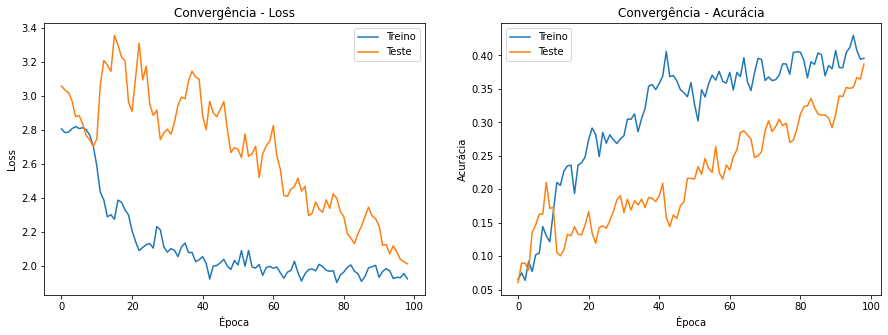

In [130]:
import matplotlib.pyplot as plt

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15,5))

ax1.plot(loss_treino[1:], label='Treino')
ax1.plot(loss_teste[1:], label='Teste')
ax1.set_title('Convergência - Loss')
ax1.set_xlabel('Época')
ax1.set_ylabel('Loss')
ax1.legend()

ax2.plot(acc_treino[1:], label='Treino')
ax2.plot(acc_teste[1:], label='Teste')
ax2.set_title('Convergência - Acurácia')
ax2.set_xlabel('Época')
ax2.set_ylabel('Acurácia')
ax2.legend()

## Usando o modelo após o treino

In [139]:
def predicao(nome):

    rnn.eval()

    nome = nomeToTensor(nome).to(device)

    saida = rnn(nome)

    topv, topi = saida.data.topk(3, 1, True)

    for value, index in zip(topv[0], topi[0]):
        print('(%.2f) %s' % (value, categorias[index]))
    print('\n')

In [141]:
predicao(b'Merkel')

(-1.59) Irish
(-1.85) German
(-1.94) Scottish




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [144]:
predicao(b'Hirobumi')

(-0.92) Japanese
(-2.00) Portuguese
(-2.21) Italian




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.


In [147]:
predicao(b'Pereira')

(-1.23) Portuguese
(-1.31) Spanish
(-1.78) Italian




/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:20: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
